# Banknote Authentication Clustering Project

This project will use the unsupervised learning technique of k-means clustering to attempt to classify the data in this binary classification problem. The UCI BankNote Authentication dataset contains 4 features relating to each banknote, where each banknote is classified as real or fake. A wavelet transform tool was used to extract the 4 features from the images obtained of the banknotes to create this dataset. Only 2 featues will be selected from the dataset in this notebook due to ease of visualising the clustering in 2D space.   

Link to dataset: https://www.kaggle.com/datasets/ritesaluja/bank-note-authentication-uci-data

## 1. Import Required Modules and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

df = pd.read_csv('BankNote_Authentication.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [2]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


Based on the output from the above cell the following observations can be made:
* **(1)** There are no missing values as the count is equal for each of the 4 features.
* **(2)** Each feature has the same number of occurrances; 1372.
* **(3)** Each feature is on a different scale, indicated by the min and max measures.

In [3]:
df["class"].value_counts()

0    762
1    610
Name: class, dtype: int64

From the output of the cell above it can be seen that the classes are not balanced in the dataset. This is not a concern for this clustering project, but is worth keeping in mind for any supervised learning tasks using this data. 

There are two classifications, therefore this is a binary classification problem. This means that k=2 for the k-means algorithm.

## 1.1 Outlier Detection
In this section, each of the 4 features will be inspected for outliers.

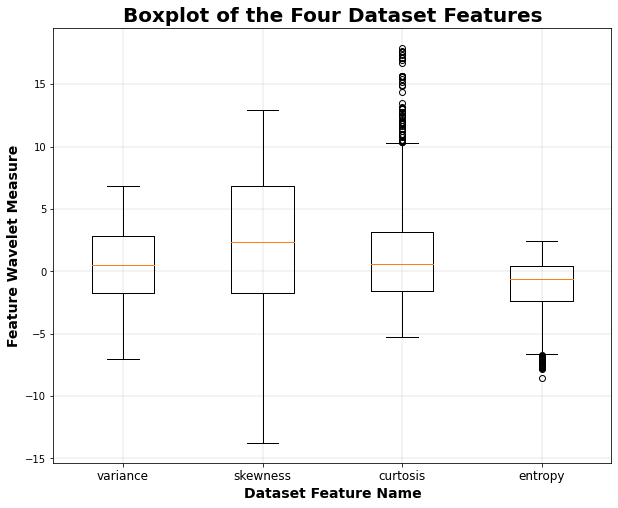

In [4]:
# Check for outliers with a boxplot:
plt.figure(figsize=(10,8))
plt.boxplot(df.iloc[:,:-1])   
plt.grid(linewidth=0.3)
plt.xticks([1,2,3,4], labels=df.columns[:-1], fontsize=12)
plt.title("Boxplot of the Four Dataset Features", fontweight='bold', fontsize=20)
plt.xlabel("Dataset Feature Name", fontweight='bold', fontsize=14)
plt.ylabel("Feature Wavelet Measure", fontweight='bold', fontsize=14)
plt.show()

From the boxplot in the cell above, it can be seen that the variance and skewness features do not have any outliers but the curtosis and entropy features do have outliers. 

At this early stage, the first two features look to be most suitable to select for k-means clustering, due to the lack of outliers and the relatively high variance.

## 1.2 Normalising of Features
The features will be normalised so that they all fall into the range of [0,1]. This ensures that all features are treated equally with the k-means algorithm as this prevents one feature dominating due to its larger scale.
This normalisation will be achieved through the use of the minmax_scale scikit-learn function.

In [5]:
scaled_data = minmax_scale(df.iloc[:,:-1], copy=True) # Dont scale the final 'class' column
scaled_df = pd.DataFrame(scaled_data, columns=(['F1','F2','F3','F4'])) # Convert scaled numpy array to a dataframe

In [6]:
scaled_df.describe()

,F1,F2,F3,F4
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.539114,0.587301,0.287924,0.668917
std,0.205003,0.219611,0.185669,0.191041
min,0.000000,0.000000,0.000000,0.000000
25%,0.379977,0.451451,0.159869,0.557821
50%,0.543617,0.602168,0.254280,0.723929
75%,0.711304,0.770363,0.364674,0.813171
max,1.000000,1.000000,1.000000,1.000000


## 1.3 Feature Pair Selection
As this is a binary classification problem, the k-means algorithm will only have 2 clusers. For ease of visualising, only two features will be selected from the data. The decision of which 2 features to be selected, will be made based on analysis performed in the next few cells. This decision will depend on which 2 features will yield the best clustering results, compared to the ground truth data labels.

In [7]:
# The pairs dictionary contains the 6 possible combinations of the 4 dataset features:
pairs = { 
1: ['F1','F2'],
2:['F1','F3'],
3:['F1','F4'],
4:['F2','F3'],
5:['F2','F4'],
6:['F3','F4'] }

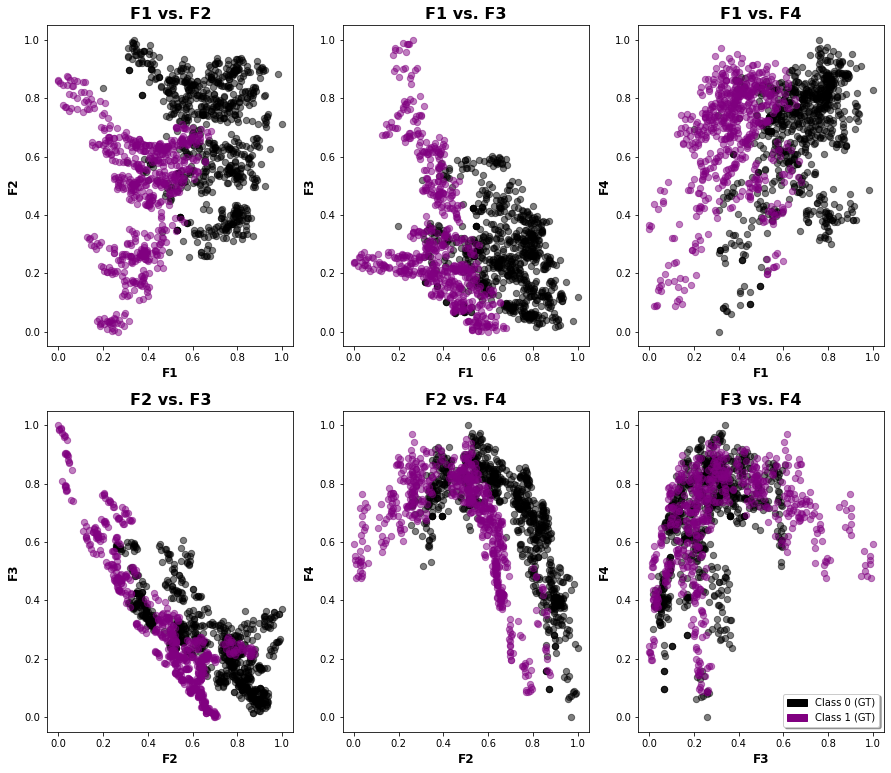

In [8]:
# Plot each feature pair for inspection:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 13))

for i in pairs:
    A = pairs[i][0]
    B = pairs[i][1]
    plt.subplot(2, 3, i)
    # Add GT class 0 as black colour:
    plt.scatter(scaled_df[A][df["class"]==0], scaled_df[B][df["class"]==0], alpha=0.5, s=40, c="black")
    # Add GT class 1 as purple colour:
    plt.scatter(scaled_df[A][df["class"]==1], scaled_df[B][df["class"]==1], alpha=0.5, s=40, c="purple")
    plt.title("{} vs. {}".format(pairs[i][0], pairs[i][1]), fontweight='bold', fontsize=16)
    plt.xlabel("{}".format(pairs[i][0]), fontweight='bold', fontsize=12)
    plt.ylabel("{}".format(pairs[i][1]), fontweight='bold', fontsize=12)
    
black_patch = mpatches.Patch(color='black', label = "Class 0 (GT)")
purple_patch = mpatches.Patch(color='purple', label='Class 1 (GT)')
plt.legend(handles=[black_patch, purple_patch], shadow="true", loc="lower right")
plt.show()

From the 6 plots in the above cell, it can be seen that there is a lot of overlap of the data classifications in the bottom 3 plots. This will result in a poor performing k-means clustering, so these 3 combinations of features will not be used. 
From the top 3 plots, the left plot appears to have two clusers that are more distinct compared to plots 2 and 3. Additionally there seems to be less overlap between the clusters in the left plot. Therefore features F1 and F2 will initially be selected for the k-means clustering, as this is likely to give the best results compared to the ground truth labels.

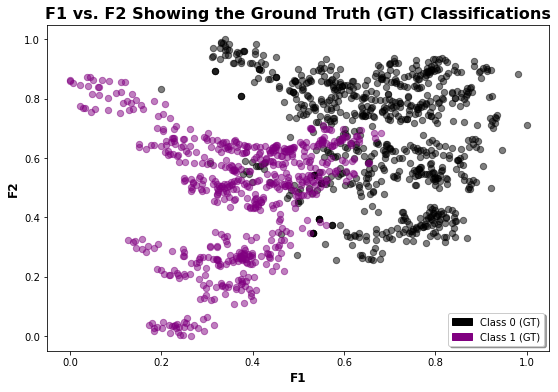

In [9]:
# Plot F1 and F2 K-Means Cluser points:
plt.figure(figsize=(9,6))
# Add cluster 1 as black:
plt.scatter(scaled_df["F1"][df["class"]==0], scaled_df["F2"][df["class"]==0], alpha=0.5, s=40, c="black")
# Add cluster 2 as Purple:
plt.scatter(scaled_df["F1"][df["class"]==1], scaled_df["F2"][df["class"]==1], alpha=0.5, s=40, c="purple")

plt.title("F1 vs. F2 Showing the Ground Truth (GT) Classifications", fontweight='bold', fontsize=16)
plt.xlabel("F1", fontweight='bold', fontsize=12)
plt.ylabel("F2", fontweight='bold', fontsize=12)
black_patch = mpatches.Patch(color='black', label = "Class 0 (GT)")
purple_patch = mpatches.Patch(color='purple', label='Class 1 (GT)')
plt.legend(handles=[black_patch, purple_patch], shadow="true", loc="lower right")
plt.show()

It can be seen in the graph above that the data ground truth labels roughly divide the data into two distinct clusters. There is some overlap in the centre of the graph between the clusters where the k-means alogorithm will likely have difficulty assigning the correct classification. 

## 2. K-Means Clustering

In [10]:
kmeans_result = KMeans(n_clusters=2).fit(scaled_data[:,:2]) # Use F1 and F2 only
clusters = kmeans_result.cluster_centers_
iterations = kmeans_result.n_iter_
kmeans_labels = kmeans_result.labels_

print("No. of Iterations:", iterations)
print("K-Means Cluser Points = ","\n", clusters)

No. of Iterations: 8
K-Means Cluser Points =  
 [[0.67364922 0.69798136]
 [0.36955897 0.44781178]]


In [11]:
kmeans_classification_df = pd.DataFrame(kmeans_labels, columns=["K-Means"])
df["kmeans"] = kmeans_labels
df.head()

,variance,skewness,curtosis,entropy,class,kmeans
0,3.62160,8.6661,-2.8073,-0.44699,0,0
1,4.54590,8.1674,-2.4586,-1.46210,0,0
2,3.86600,-2.6383,1.9242,0.10645,0,0
3,3.45660,9.5228,-4.0112,-3.59440,0,0
4,0.32924,-4.4552,4.5718,-0.98880,0,1


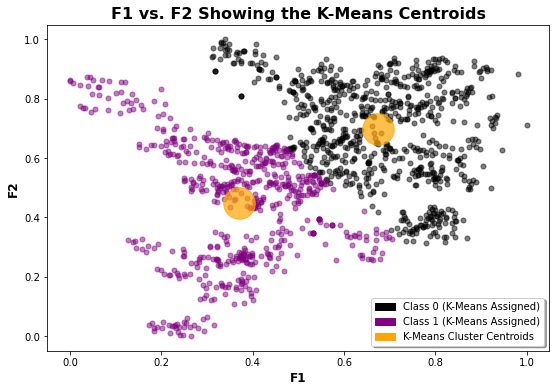

In [12]:
# Plot K-Means Cluser points:
plt.figure(figsize=(9,6))
# Add cluster 1 as black:
plt.scatter(scaled_df["F1"][df["kmeans"]==0], scaled_df["F2"][df["kmeans"]==0], alpha=0.5, s=25, c="black")
# Add cluster 2 as Purple:
plt.scatter(scaled_df["F1"][df["kmeans"]==1], scaled_df["F2"][df["kmeans"]==1], alpha=0.5, s=25, c="purple")
# Add the kmeans cluser centroids:
plt.scatter(clusters[:,0], clusters[:,1], alpha=0.7, s=1000, color='orange')

plt.title("F1 vs. F2 Showing the K-Means Centroids", fontweight='bold', fontsize=16)
plt.xlabel("F1", fontweight='bold', fontsize=12)
plt.ylabel("F2", fontweight='bold', fontsize=12)
black_patch = mpatches.Patch(color='black', label = "Class 0 (K-Means Assigned)")
purple_patch = mpatches.Patch(color='purple', label='Class 1 (K-Means Assigned)')
orange_patch = mpatches.Patch(color='orange', label='K-Means Cluster Centroids')
plt.legend(handles=[black_patch, purple_patch, orange_patch], shadow="true", loc="lower right")
plt.show()

Next, the points will be coloured according to being correctly or incorrectly clustered, according to the ground truth classification labels.

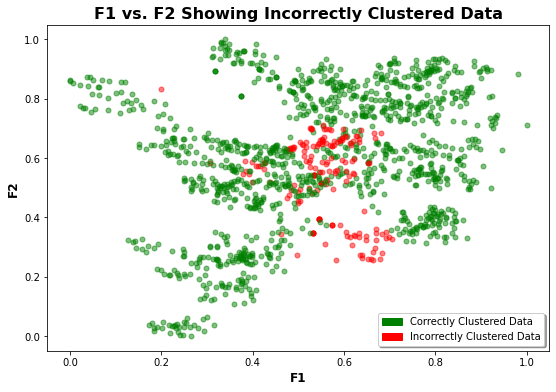

In [87]:
plt.figure(figsize=(9,6))
for i in scaled_df.iterrows():
    if df['kmeans'][i[0]] == df["class"][i[0]]:
        plt.scatter(scaled_df["F1"][i[0]], scaled_df["F2"][i[0]], alpha=0.5, s=25, c="green")
    else:
        plt.scatter(scaled_df["F1"][i[0]], scaled_df["F2"][i[0]], alpha=0.5, s=25, c="red")

plt.title("F1 vs. F2 Showing Incorrectly Clustered Data", fontweight='bold', fontsize=16)
plt.xlabel("F1", fontweight='bold', fontsize=12)
plt.ylabel("F2", fontweight='bold', fontsize=12)
black_patch = mpatches.Patch(color='green', label = "Correctly Clustered Data")
purple_patch = mpatches.Patch(color='red', label='Incorrectly Clustered Data')
plt.legend(handles=[black_patch, purple_patch], shadow="true", loc="lower right")        
plt.show()     

As expected, it is mainly the overlapping data points in the centre of the graph which were incorrectly clustered. 

## 3. Accuracy Metrics and Additional Feature Inevstigation
The k-means clusering classification accuracy will be compared to the ground truth labels in this section.

In [14]:
acc_score = accuracy_score(y_true=df["class"], y_pred=df["kmeans"], normalize=True, sample_weight=None)

In [15]:
print(acc_score.round(3))

0.872


In [16]:
from sklearn.metrics import confusion_matrix
c =confusion_matrix(y_true=df["class"], y_pred=df["kmeans"])
print(c)

[[676  86]
 [ 89 521]]


The confusion matrix above indicates that its roughly an even amount of data from each class that are incorrectly classified with the k-means clustering algorithm. Overall the classification accuracy is 87.2% compared to the grount truth labels.

Next, the k-means algorithm will be run for each of the 6 combinations of the four dataset features as this will help to verify that choosing F1 and F2 yielded the best clustering results compared to the ground truth labels.

['F1', 'F2'] , accuracy: 0.872
['F1', 'F3'] , accuracy: 0.764
['F1', 'F4'] , accuracy: 0.831
['F2', 'F3'] , accuracy: 0.586
['F2', 'F4'] , accuracy: 0.59
['F3', 'F4'] , accuracy: 0.493


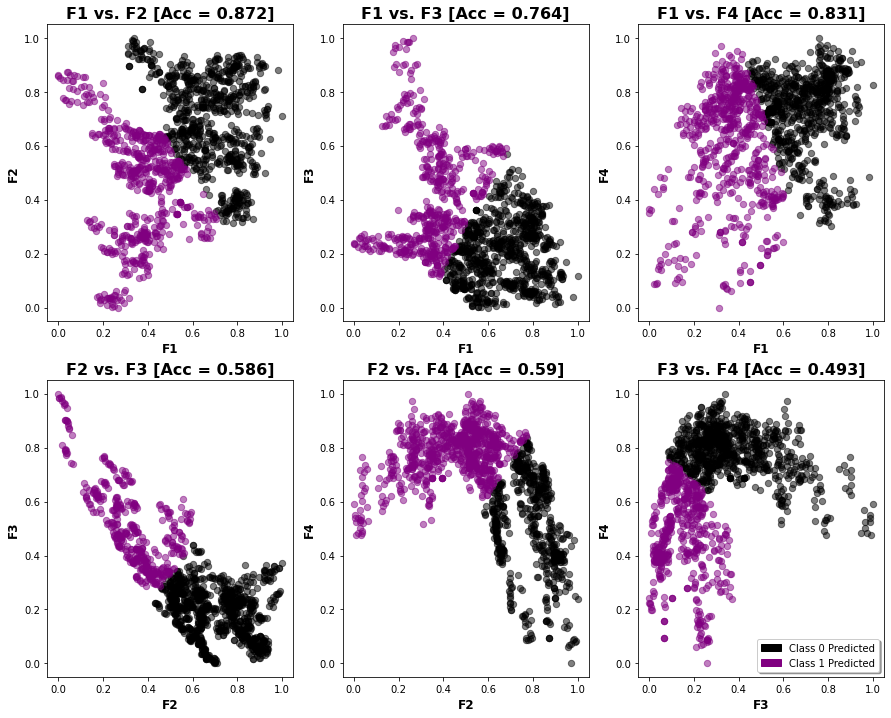

In [86]:
accuracy_scores = []
fig, ax = plt.subplots(3, 2, figsize=(15,12))

for i in pairs: 
    A = pairs[i][0]
    B = pairs[i][1]
    kmeans_result = KMeans(n_clusters=2).fit(scaled_df[[A,B]])
    clusters = kmeans_result.cluster_centers_
    kmeans_labels = kmeans_result.labels_
    kmeans_labels_df = pd.DataFrame(kmeans_labels, columns=["Class"])
    acc_score = accuracy_score(y_true=df["class"], y_pred=kmeans_labels, normalize=True, sample_weight=None)
    accuracy_scores.append(acc_score.round(3))
    print(pairs[i], ", accuracy:", acc_score.round(3))
    
    # Graph the clusters:
    plt.subplot(2, 3, i)
    # Add k-means class 0 black:
    plt.scatter(scaled_df[A][kmeans_labels_df["Class"]==0], scaled_df[B][kmeans_labels_df["Class"]==0], alpha=0.5, s=40, c="black")
    # Add k-means class 1 as Purple:
    plt.scatter(scaled_df[A][kmeans_labels_df["Class"]==1], scaled_df[B][kmeans_labels_df["Class"]==1], alpha=0.5, s=40, c="purple")

    plt.title("{} vs. {} [Acc = {}]".format(A, B, acc_score.round(3)), fontweight='bold', fontsize=16)
    plt.xlabel("{}".format(A), fontweight='bold', fontsize=12)
    plt.ylabel("{}".format(B), fontweight='bold', fontsize=12)

black_patch = mpatches.Patch(color='black', label = "Class 0 Predicted")
purple_patch = mpatches.Patch(color='purple', label='Class 1 Predicted')
plt.legend(handles=[black_patch, purple_patch], shadow="true", loc="lower right")

From the output of the cell above it can be seen that the k-means algorithm has difficulty assigning the data to clusers where the data from each class overlaps. As expected with the initial selection, features F1 (variance) and F2 (skewness) provide the best clustering result in terms of classification accuracy in this case, followed by F1 (variance) and F4 (entropy).

## 4. Conclusion


K-means clustering has been used to effectively cluster the data into two groups using 2 selected features from the UCI banknote dataset. For further work, k-means could be used in higher dimensional space or supervised learning techniques could be used to attempt to better classify the data. 